In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
PROJECT_ROOT = Path().resolve()
load_dotenv(PROJECT_ROOT / ".env")

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_API_SECRET")

if not API_KEY or not API_SECRET:
    raise RuntimeError(
        "Missing Alpaca credentials. Set ALPACA_API_KEY and ALPACA_API_SECRET in the OS "
        "environment or create Stonks/trade_bot/.env with those keys."
    )

# Just import the 3 clients available
from alpaca.data import (
    CryptoHistoricalDataClient,
    StockHistoricalDataClient,
    OptionHistoricalDataClient,
)

# no keys required.
crypto_client = CryptoHistoricalDataClient()

# keys required
stock_client = StockHistoricalDataClient(API_KEY, API_SECRET)
option_client = OptionHistoricalDataClient(API_KEY, API_SECRET)


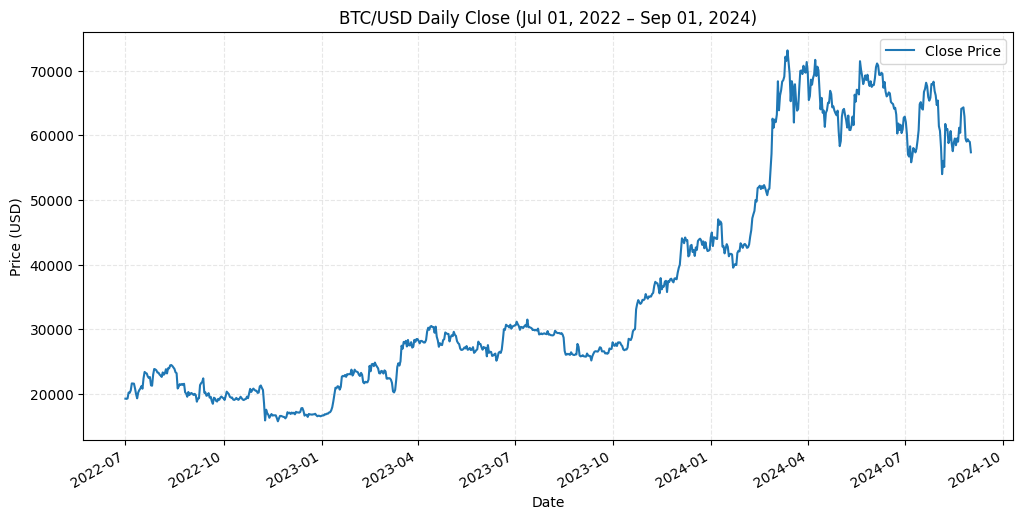

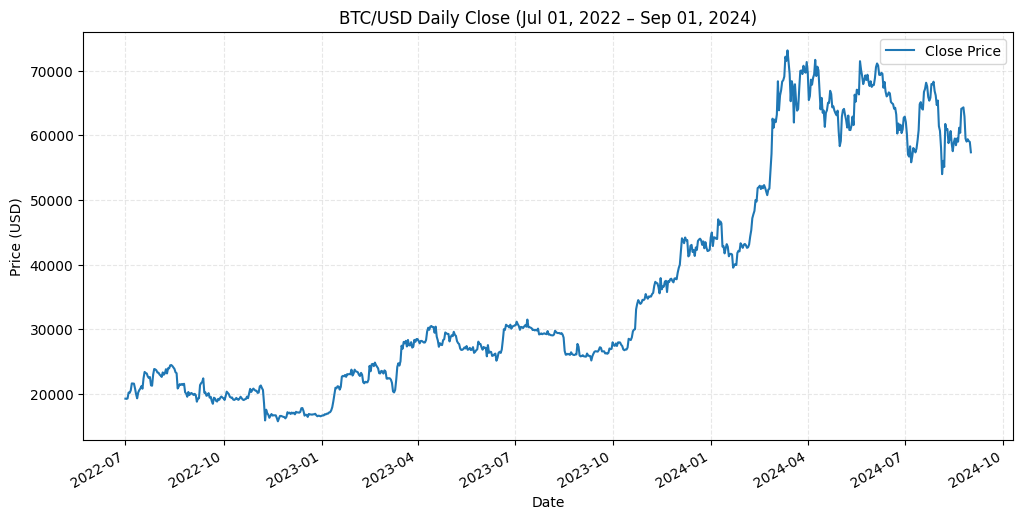

In [3]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Date range configuration
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 9, 1)
date_label = f"{start_date:%b %d, %Y} – {end_date:%b %d, %Y}"

# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD", "ETH/USD"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date,
)

bars = client.get_crypto_bars(request_params)

btc_bars = bars["BTC/USD"]

btc_df = pd.DataFrame(
    {
        "timestamp": [bar.timestamp for bar in btc_bars],
        "open": [bar.open for bar in btc_bars],
        "high": [bar.high for bar in btc_bars],
        "low": [bar.low for bar in btc_bars],
        "close": [bar.close for bar in btc_bars],
        "volume": [bar.volume for bar in btc_bars],
    }
).set_index("timestamp")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(btc_df.index, btc_df["close"], label="Close Price", color="tab:blue")
ax.set_title(f"BTC/USD Daily Close ({date_label})")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend()

fig.autofmt_xdate()
fig

In [4]:
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass

trading_client = TradingClient(API_KEY, API_SECRET)

# search for crypto assets
search_params = GetAssetsRequest(
    asset_class=AssetClass.US_EQUITY, status="active", exchange="NASDAQ"
)

active_assets_nasdaq = trading_client.get_all_assets(search_params)

print(f"Found {len(active_assets_nasdaq)} assets")

Found 5125 assets


Figure(1200x600)
Start Price: 138.93
End Price: 229.0
Profit: 90.07
Percent Change: 64.83


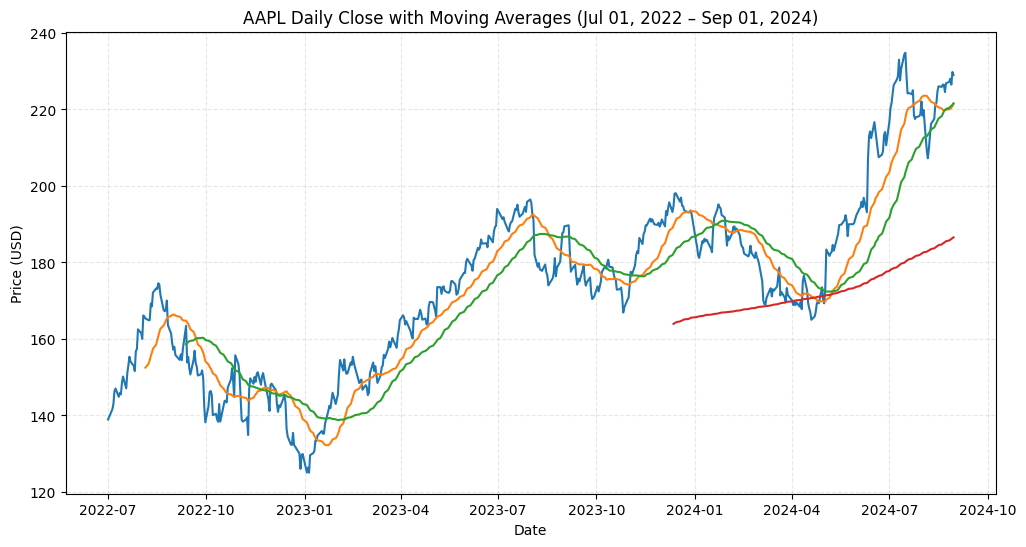

In [12]:
# Moving average example on apple stock
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Date range configuration
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 9, 1)
date_label = f"{start_date:%b %d, %Y} – {end_date:%b %d, %Y}"

# keys required for stock data
client = StockHistoricalDataClient(API_KEY, API_SECRET)
# Request daily bars for AAPL
request_params = StockBarsRequest(
    symbol_or_symbols=["AAPL"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date,
)
# Bars is a dictionary of symbol to list of bars
bars = client.get_stock_bars(request_params)
aapl_bars = bars["AAPL"]
# DataFrame so we can do moving average in pandas
aapl_df = pd.DataFrame(
    {
        "timestamp": [bar.timestamp for bar in aapl_bars],
        "open": [bar.open for bar in aapl_bars],
        "high": [bar.high for bar in aapl_bars],
        "low": [bar.low for bar in aapl_bars],
        "close": [bar.close for bar in aapl_bars],
        "volume": [bar.volume for bar in aapl_bars],
    }
).set_index("timestamp")

aapl_df["25_MovingAverage"] = aapl_df["close"].rolling(window=25).mean()
aapl_df["50_MovingAverage"] = aapl_df["close"].rolling(window=50).mean()
aapl_df["365_MovingAverage"] = aapl_df["close"].rolling(window=365).mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(aapl_df.index, aapl_df["close"], label="Close Price", color="tab:blue")
ax.plot(
    aapl_df.index, aapl_df["25_MovingAverage"], label="25-Day MA", color="tab:orange"
)
ax.plot(
    aapl_df.index, aapl_df["50_MovingAverage"], label="50-Day MA", color="tab:green"
)
ax.plot(
    aapl_df.index, aapl_df["365_MovingAverage"], label="365-Day MA", color="tab:red"
)

ax.set_title(f"AAPL Daily Close with Moving Averages ({date_label})")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")

ax.grid(True, linestyle="--", alpha=0.3)
print(fig)
print("Start Price:", aapl_df["close"].iloc[0])
print("End Price:", aapl_df["close"].iloc[-1])
print("Profit:", aapl_df["close"].iloc[-1] - aapl_df["close"].iloc[0])
print(
    "Percent Change:",
    round(
        (aapl_df["close"].iloc[-1] - aapl_df["close"].iloc[0])
        / aapl_df["close"].iloc[0]
        * 100,
        2,
    ),
)

In [13]:
# Risk calculation testing

returns = aapl_df["close"].pct_change().dropna()  # daily returns

expected_daily_return = returns.mean()
expected_annual_return = (
    1 + expected_daily_return
) ** 252 - 1  # 252 trading days in a year

daily_volatility = returns.std()
expected_annual_volatility = daily_volatility * (252**0.5)  # annualized volatility

print(f"Expected daily return: {expected_daily_return:.4f}")
print(f"Expected annual return: {expected_annual_return:.2%}")
print(f"Daily volatility: {daily_volatility:.4f}")
print(f"Annual volatility: {expected_annual_volatility:.2%}")

Expected daily return: 0.0011
Expected annual return: 30.28%
Daily volatility: 0.0163
Annual volatility: 25.81%
